# SVM Regression
This will load the csv testing and training files into Dataframes

Your Directory should be set up like this:
```
.
│
├── Notebook_Files
│   ├── Data Normalization.ipynb
│   ├── Master Template.ipynb
│   └── Random Forrest.ipynb
├── Source
│   ├── sample_submission.csv
│   ├── test.csv
│   └── train.csv
└── tmdb-box-office-prediction.zip

```

`train_df` - Holds training data

`test_df` - Holds testing data

`orig_df` - Original training data

In [1]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVR
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn import metrics

train_df = pd.read_csv('../Source/train.csv')
test_df = pd.read_csv("../Source/test.csv")
orig_df = pd.read_csv('../Source/train.csv')


## normalize(df) function
This function needs to be ran on both testing and training data
It takes in a Pandas DataFrame and returns a DataFrame
```
How to use:
df = normalize(df)
```

In [2]:
def encode_list(row, json_tag):
    genre = []
    try:
        data = eval(row)
    except:
        data = {}
    for i in data:
        genre.append(i.get(json_tag))
    return genre

def encode_list_to_count(row, json_tag):
    genre = []
    try:
        data = eval(row)
    except:
        data = {}
    count = 0
    for i in data:
        count += 1
    return count


def normalize(df):
    
    mlb = MultiLabelBinarizer()
    
    ## Count spoken languages 
    df['language_count'] = df['spoken_languages'].apply(lambda x: encode_list_to_count(x, 'iso_639_1'))
    df.pop('spoken_languages')
    
    ## Count Producion COuntry
    df['prod_country_encoded'] = df['production_countries'].apply(lambda x: encode_list(x, 'name'))
    df['produced_in_usa'] = df['prod_country_encoded'].apply(lambda x: 1 if 'United States of America' in x else 0)
    df['prod_country_counted'] = df['production_countries'].apply(lambda x: encode_list_to_count(x, 'name'))
    df.pop('production_countries')
    df.pop('prod_country_encoded')
    
    ## Encode Genre
    df['genre_encoded'] = df['genres'].apply(lambda x: encode_list(x, 'name'))
    df_encoded = pd.DataFrame(mlb.fit_transform(df['genre_encoded']),columns=mlb.classes_, index=df.index)
    df = pd.concat([df,df_encoded], axis=1)
    df.pop('genres')
    df.pop('genre_encoded')
    
    ## Run Time
    df['runtime'] = df['runtime'].replace(np.nan, 0)
    
    ## Crew Count
    df['count_of_crew'] = df['crew'].apply(lambda x: encode_list_to_count(x,'cred_id' ))
    df. pop('crew')

    ## Cast Count
    df['count_of_cast'] = df['cast'].apply(lambda x: encode_list_to_count(x,'cast_id' ))
    df. pop('cast')
    
    ## Production Companies Count
    df['production_companies_count'] = df['production_companies'].apply(lambda x: encode_list_to_count(x,'name' ))
    df. pop('production_companies')
    
    
    ## ENCODE IF ORIGINAL LANGUAGE WAS ENGLISH
    df['orig_lang_is_eng'] = df['original_language'].apply(lambda x: 1 if 'en' in x else 0)
    df.pop('original_language')
    
    ## Cast date to a date type and correct outliers
    current_year = pd.Timestamp(year=2023, month=1, day=1, hour=0, minute=0, second=0)
    df['date'] = pd.to_datetime(df['release_date'])
    df['date'] = df['date'].apply(lambda x: x - pd.DateOffset(years=100) if x > current_year else x)
    df.pop('release_date')
    
    ## Create release month int value
    df['release_month'] = df["date"].dt.month
    df.pop('date')  ## You can remove this if you want to used the date somehow
    
    ## Encode Collection status 
    df['belongs_to_collection'] = df['belongs_to_collection'].apply(lambda x: encode_list_to_count(x, 'name'))
    
    # drop irrelevant/unused columns
    df.pop('tagline')
    df.pop('Keywords')
    df.pop('overview')
    df.pop('id')
    df.pop('belongs_to_collection')
    df.pop('homepage')
    df.pop('imdb_id')
    df.pop('original_title')
    df.pop('poster_path')
    df.pop('title')
    df.pop('status')
    
    return df

### Normalize Train and Test data

In [3]:
train_df = normalize(train_df)
test_df = normalize(test_df)

### Adding average to budget values of 0

In [4]:
# var holding total budget
total_budget = 0
count = 0

# for loop traversing budget
for entry in train_df['budget']:
    total_budget += entry
    if entry != 0:
        count += 1
    
# finding average and adding it to entries with 0 value
budget_avg = total_budget / count
train_df.loc[train_df['budget'] == 0, 'budget'] = budget_avg
train_df[:5]

,budget,popularity,runtime,revenue,language_count,produced_in_usa,prod_country_counted,Action,Adventure,Animation,...,Science Fiction,TV Movie,Thriller,War,Western,count_of_crew,count_of_cast,production_companies_count,orig_lang_is_eng,release_month
0,1.400000e+07,6.575393,93.0,12314651,1,1,1,0,0,0,...,0,0,0,0,0,72,24,3,1,2
1,4.000000e+07,8.248895,113.0,95149435,1,1,1,0,0,0,...,0,0,0,0,0,9,20,1,1,8
2,3.300000e+06,64.299990,105.0,13092000,1,1,1,0,0,0,...,0,0,0,0,0,64,51,3,1,10
3,1.200000e+06,3.174936,122.0,16000000,2,0,1,0,0,0,...,0,0,1,0,0,3,7,0,0,3
4,3.089305e+07,1.148070,118.0,3923970,1,0,1,1,0,0,...,0,0,1,0,0,2,4,0,0,2


In [5]:
# import tool
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import scale

# split data
feature_cols = list(train_df.columns)
feature_cols.remove('revenue')
X = train_df[feature_cols]
y = pd.DataFrame(train_df['revenue'])

# scale feature data
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

# check size of sets
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(2100, 31)
(900, 31)
(2100, 1)
(900, 1)


In [51]:
# import tools

from sklearn.model_selection import GridSearchCV

# dictionary with parameters to test
params = {'C': [x*2000 for x in range(5,10)],
              'epsilon': [0.10 , 0.20, 0.25, 0.30],
              'kernel' : ['rbf'],
              'gamma': [0.001, 0.0001, 0.00001, 0.00011]}
# create regressor
regressor = SVR()

# create grid
xgb_grid = GridSearchCV(regressor,
                        params,
                        cv = 10,
                        scoring='r2',
                        verbose=10)

# fit the grid
xgb_grid.fit(X_train, y_train.ravel())

# see results
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 10 folds for each of 80 candidates, totalling 800 fits
[CV 1/10; 1/80] START C=10000, epsilon=0.1, gamma=0.001, kernel=rbf.............
[CV 1/10; 1/80] END C=10000, epsilon=0.1, gamma=0.001, kernel=rbf;, score=0.163 total time=   5.0s
[CV 2/10; 1/80] START C=10000, epsilon=0.1, gamma=0.001, kernel=rbf.............
[CV 2/10; 1/80] END C=10000, epsilon=0.1, gamma=0.001, kernel=rbf;, score=0.745 total time=   5.5s
[CV 3/10; 1/80] START C=10000, epsilon=0.1, gamma=0.001, kernel=rbf.............
[CV 3/10; 1/80] END C=10000, epsilon=0.1, gamma=0.001, kernel=rbf;, score=0.564 total time=   5.3s
[CV 4/10; 1/80] START C=10000, epsilon=0.1, gamma=0.001, kernel=rbf.............
[CV 4/10; 1/80] END C=10000, epsilon=0.1, gamma=0.001, kernel=rbf;, score=0.631 total time=   5.0s
[CV 5/10; 1/80] START C=10000, epsilon=0.1, gamma=0.001, kernel=rbf.............
[CV 5/10; 1/80] END C=10000, epsilon=0.1, gamma=0.001, kernel=rbf;, score=0.560 total time=   5.3s
[CV 6/10; 1/80] START C=10000, epsilo

## Best Parameters
### 'C': 10000, 'epsilon': 0.3, 'gamma': 0.0001, 'kernel': 'rbf'}

In [6]:

regressor = SVR(C=10000, epsilon=0.3, gamma=0.0001, kernel='rbf')

regressor.fit(X_train, y_train)
y_predict = regressor.predict(X_test)

/usr/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2_score: 0.650672123344329 
RMSE: 72318471.8892055


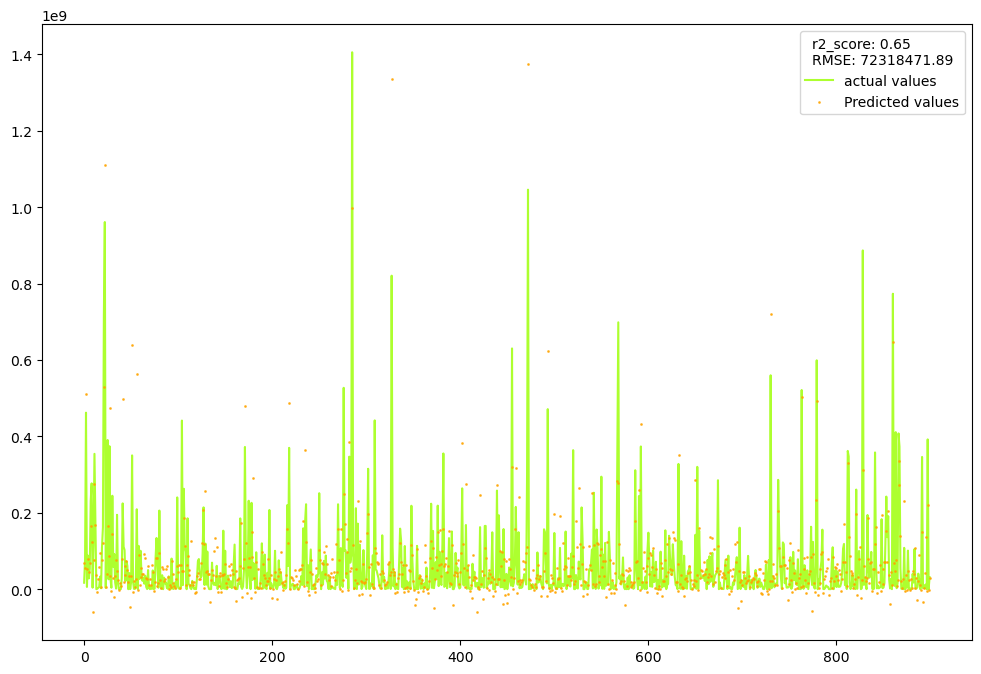

In [7]:
plt.figure(figsize=(12, 8))
y_predict = sc_y.inverse_transform(pd.DataFrame(y_predict)) 
y_test = sc_y.inverse_transform(pd.DataFrame(y_test)) 
# plotting the graph for the actual values
plt.plot([i for i in range(len(y_test))],y_test, label="actual values", c='greenyellow')

# plotting the graph for predictions
plt.scatter([i for i in range(len(y_test))],y_predict, label="Predicted values", c='orange',alpha=0.75,s=1,zorder=10)



mse = metrics.mean_squared_error(y_test, y_predict)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,y_predict)
print( f"r2_score: {r2} \nRMSE: {rmse}")
plt.legend(title=f"r2_score: {r2:.2f}\nRMSE: {rmse:.2f}")
plt.show()

## Show averages against 100 train test splits

In [8]:
# import tool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# split data
train_df = pd.read_csv('../Source/train.csv')
train_df = normalize(train_df)
feature_cols = list(train_df.columns)
feature_cols.remove('revenue')
X = train_df[feature_cols]
y = train_df['revenue']

r2_average = 0;
rmse_average = 0;
number_of_loops = 100

for j in range(0,number_of_loops):
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X_loop = sc_X.fit_transform(X)
    y_loop = sc_y.fit_transform(pd.DataFrame(y))
    X_train, X_test, y_train, y_test = train_test_split(X_loop, y_loop, test_size=.10, random_state=j)
    
    RF_best = model = SVR(C=10000, epsilon=.3, gamma=0.0001, kernel='rbf')
    RF_best.fit(X_train, y_train.ravel())
    y_pred = RF_best.predict(X_test)    
    
    #  fitting the size of the plot
    #plt.figure(figsize=(12, 8))
    #plt.title(f"ADABoost\nRandom State {j}")
    #plt.yticks([1000000,100000000, 1000000000], ['1 Million', '100 Million', '1 Billion' ])


    y_pred = sc_y.inverse_transform(pd.DataFrame(y_pred)) 
    y_test = sc_y.inverse_transform(pd.DataFrame(y_test)) 

    # Draw line for 0 values
    #plt.axhline(y=0, linestyle='dotted')

    # plotting the graph for the actual values
    #plt.plot([i for i in range(len(y_test))],y_test, label="actual values", c='greenyellow')

    # plotting the graph for predictions
    #plt.plot([i for i in range(len(y_test))],y_pred, label="Predicted values", c='orange', alpha=0.75)#, s=5)

    
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test,y_pred)
    r2_average += r2
    rmse_average += rmse
    print( f"R2: {r2} RMSE: {rmse/1000000}\n j = {j}")
    #plt.legend(title=f"r2_score:  {r2:.3f}\nRMSE:  {rmse/1000000:.2f} million")
    #plt.savefig(f"./Plots/ADA_Boost_{j}.png")
print(f"\n R2 average: {r2_average/number_of_loops}\n RMSE Average: {(rmse_average/number_of_loops)/1000000}")

#plt.show()


R2: 0.6832356000663365 RMSE: 84.28327965899399
 j = 0
R2: 0.6360117532411054 RMSE: 74.57146598348709
 j = 1
R2: 0.5318640006334308 RMSE: 77.96130472447891
 j = 2
R2: 0.5837858855142735 RMSE: 84.27571467042802
 j = 3
R2: 0.7357792301284186 RMSE: 69.2196058919381
 j = 4
R2: 0.5572165891696421 RMSE: 64.5369702647048
 j = 5
R2: 0.6797830062195024 RMSE: 96.00401792595837
 j = 6
R2: 0.7604625483813628 RMSE: 73.46737857548847
 j = 7
R2: 0.6631907818241984 RMSE: 79.45291807818779
 j = 8
R2: 0.7286372998159183 RMSE: 61.82653067588739
 j = 9
R2: 0.6339459841458908 RMSE: 87.41973526068084
 j = 10
R2: 0.6102433545419839 RMSE: 81.18604582372036
 j = 11
R2: 0.7530009893565176 RMSE: 58.747858199314535
 j = 12
R2: 0.47186107235631525 RMSE: 75.81149286574855
 j = 13
R2: 0.5732604359449351 RMSE: 100.79961942974832
 j = 14
R2: 0.6222269035889427 RMSE: 88.87817905480696
 j = 15
R2: 0.7403321195506016 RMSE: 84.06951677312162
 j = 16
R2: 0.7085519164919516 RMSE: 80.3143743439965
 j = 17
R2: 0.56070978750683